#### Import the required dependencies

In [163]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import ta.trend as tt
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

import plotly.express as px
from plotly.subplots import make_subplots
import pmdarima as pm

In [103]:
# Setting style for every plot
plt.style.use('seaborn')

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_55270/3415471106.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



## 1. Data gathering and pre-processing

### 1.1 Webscraping companies' tickers and names

In order to create a list of companies to be displayed and the selected by user from the streamlit selectboxes, we'll webscrape the list of companies traded in a market from wikipedia in order to get the company full name and its ticker.

In [46]:
SP500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
SP500 = SP500[0] #take just the first table from the webpage
SP500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [47]:
# zip is a Python function that will iteratively aggregate the two elements (Ticker and the name of the security)
# then the dict() function create a dictionary with keys the names from 'Security' column and values the tickers from the 'Symbol' column
ticks_SP500 = dict(zip(SP500['Security'], SP500['Symbol']))

In [ ]:
# We can now repeat the same process for Nasdaq and FTSEMIB
FTSEMIB = pd.read_html('https://en.wikipedia.org/wiki/FTSE_MIB')
FTSEMIB = FTSEMIB[1]

NASDAQ = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100#Components')
NASDAQ = NASDAQ[4]

In [ ]:
FTSEMIB.head()

,Company,Ticker,ISIN,ICB Sector
0,A2A,A2A.MI,IT0001233417,7530 (Electricity)[citation needed]
1,Amplifon,AMP.MI,IT0004056880,(Health Care)
2,Azimut,AZM.MI,IT0003261697,8770 (Financial Services)[citation needed]
3,Banca Generali,BGN.MI,IT0001031084,8770 (Financial Services)
4,Banca Mediolanum,BMED.MI,IT0004776628,8770 (Financial Services)


In [ ]:
NASDAQ.head()

,Company,Ticker,GICS Sector,GICS Sub-Industry
0,Activision Blizzard,ATVI,Communication Services,Interactive Home Entertainment
1,Adobe Inc.,ADBE,Information Technology,Application Software
2,ADP,ADP,Information Technology,Data Processing & Outsourced Services
3,Airbnb,ABNB,Consumer Discretionary,Internet & Direct Marketing Retail
4,Align Technology,ALGN,Health Care,Health Care Supplies


In [ ]:
ticks_FTSE = dict(zip(FTSEMIB['Company'], FTSEMIB['Ticker']))
ticks_NASDAQ = dict(zip(NASDAQ['Company'], NASDAQ['Ticker']))

### 1.2 Gather data using tickers and Yahoo Finance API's

The main libraries we will use to download data for a security are `yahoo_fin` and `yfinance`.

The function to download data using yfinance is .download() that take as inputs the company ticker, start date and end date of the period we want to download data.

In [746]:
data = yf.download('AAPL', start='2000-01-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.849469,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.777850,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.789232,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.720933,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.755083,460734400


The function return a pandas dataframe with different columns that include informations about the opening and the closing price, the range min-max of the price of the security, the adjusted close price and the volumes traded in a specific day.

The second library that will be used is yahoo_fin. 

The first function `get_stats` is useful to download statistics about a company and `get_analysts_info` will scrape analysts' estimates.

In [48]:
from yahoo_fin.stock_info import get_stats, get_analysts_info

stats = get_stats('AAPl')
info = get_analysts_info('AAPL')

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/yahoo_fin/stock_info.py:336: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/yahoo_fin/stock_info.py:336: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/yahoo_fin/stock_info.py:336: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/yahoo_fin/stock_info.py:336: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/tommasograndi/opt/anacond

In [50]:
stats.head()

,Attribute,Value
0,Beta (5Y Monthly),1.30
1,52-Week Change 3,22.40%
2,S&P500 52-Week Change 3,5.49%
3,52 Week High 3,176.39
4,52 Week Low 3,124.17


In [52]:
info

{'Earnings Estimate':   Earnings Estimate  Current Qtr. (Jun 2023)  Next Qtr. (Sep 2023)  \
 0   No. of Analysts                    27.00                 26.00   
 1     Avg. Estimate                     1.19                  1.36   
 2      Low Estimate                     1.14                  1.17   
 3     High Estimate                     1.45                  1.51   
 4      Year Ago EPS                     1.20                  1.29   
 
    Current Year (2023)  Next Year (2024)  
 0                35.00             35.00  
 1                 5.97              6.54  
 2                 5.43              5.58  
 3                 6.29              7.25  
 4                 6.11              5.97  ,
 'Revenue Estimate':           Revenue Estimate Current Qtr. (Jun 2023) Next Qtr. (Sep 2023)  \
 0          No. of Analysts                      24                   24   
 1            Avg. Estimate                  81.67B               90.52B   
 2             Low Estimate           

The following function from yahoo_fin will be used to download the live stock price

In [45]:
from yahoo_fin.stock_info  import get_live_price

print(get_live_price('AAPL'))

175.16000366210938


## 2. Create functions for data manipulation, stock prediction and portfolio optimization

### 2.1 Functions Data Manipulation

### 2.2 Stock Prediction

#### 2.2.1 ARIMA Models

ARIMA models, or Auto Regressive Integrated Moving Average are models that can be used to fit and forecast non-stationary time series by converting the series to a stationary state using the integrated differences.

In [543]:
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
# from sklearn.metrics import mean_squared_error

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_55270/3360812903.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [747]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.849469,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.777850,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.789232,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.720933,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.755083,460734400


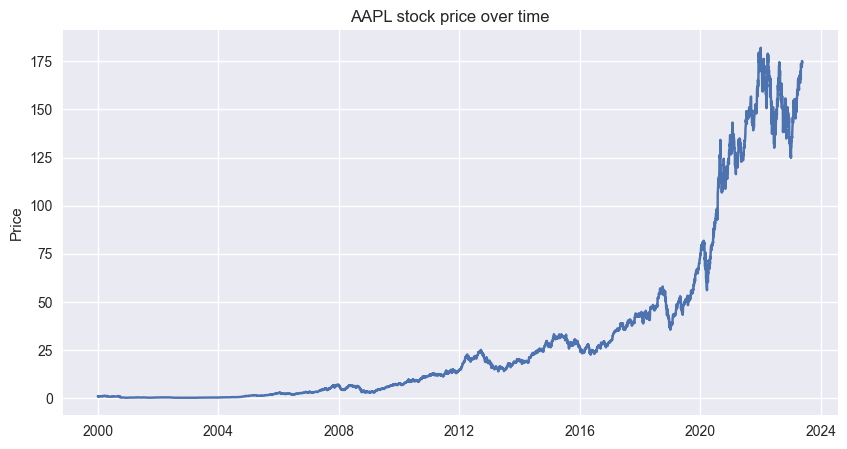

In [748]:
# Taking a look at the data

plt.figure(figsize=(10,5))
plt.plot(data.index, data["Close"])
plt.title("AAPL stock price over time")
plt.ylabel("Price")
plt.show()

As we can see the shape of this time series is very tipical for an evolution of a stock price, the series appear to be non-stationary hence the ARIMA model that is usually used for non stationarity should be fine. 

The non-stationarity in particular is a condition that affects time series whenever the mean and variance are not constant and depend on time $t$.
Stationarity usually affect series that tend to *mean-revert* but as we know financial series regarding stocks do not mean revert overtime (otherwise it would be really simple to earn a lot of money in financial markets!). 

What appear to be a stationary series is instead the daily log changes (log of difference in price and its lag(1) since the mean and variance remains mostly constant. This means that returns tend to *mean-revert* since they have usually a constant variance and mean overtime and tend to be distributed randomly around a zero mean.

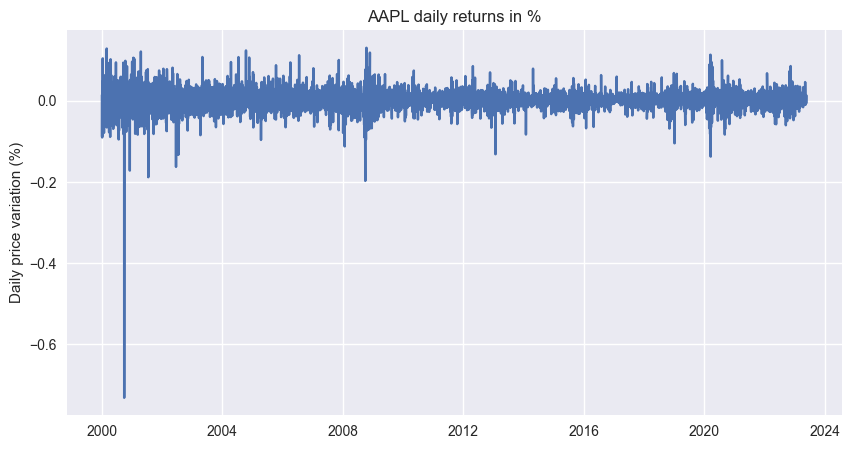

In [749]:
plt.figure(figsize=(10,5))
plt.plot(data.index, np.log(data['Close']/data['Close'].shift(1)))
plt.title("AAPL daily returns in %")
plt.ylabel("Daily price variation (%)")
plt.show()


To confirm our non-stationary hypotheses we may want to take also a look at correlation and in particular at cross correlation (autocorrelation) at different time-lags.

First we'll define a dataframe containing the closing price and the lags.

In [750]:
lags = pd.DataFrame(data['Close'])
for i in range(1, 10):
    lags[f'Lag {i}'] = data['Close'].shift(i)
lags.dropna(0, inplace=True)
lags.head()

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_55270/825019365.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.



,Close,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9
Date,,,,,,,,,,
2000-01-14,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.999442
2000-01-18,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179
2000-01-19,0.951451,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571
2000-01-20,1.013393,0.951451,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214
2000-01-21,0.993862,1.013393,0.951451,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393


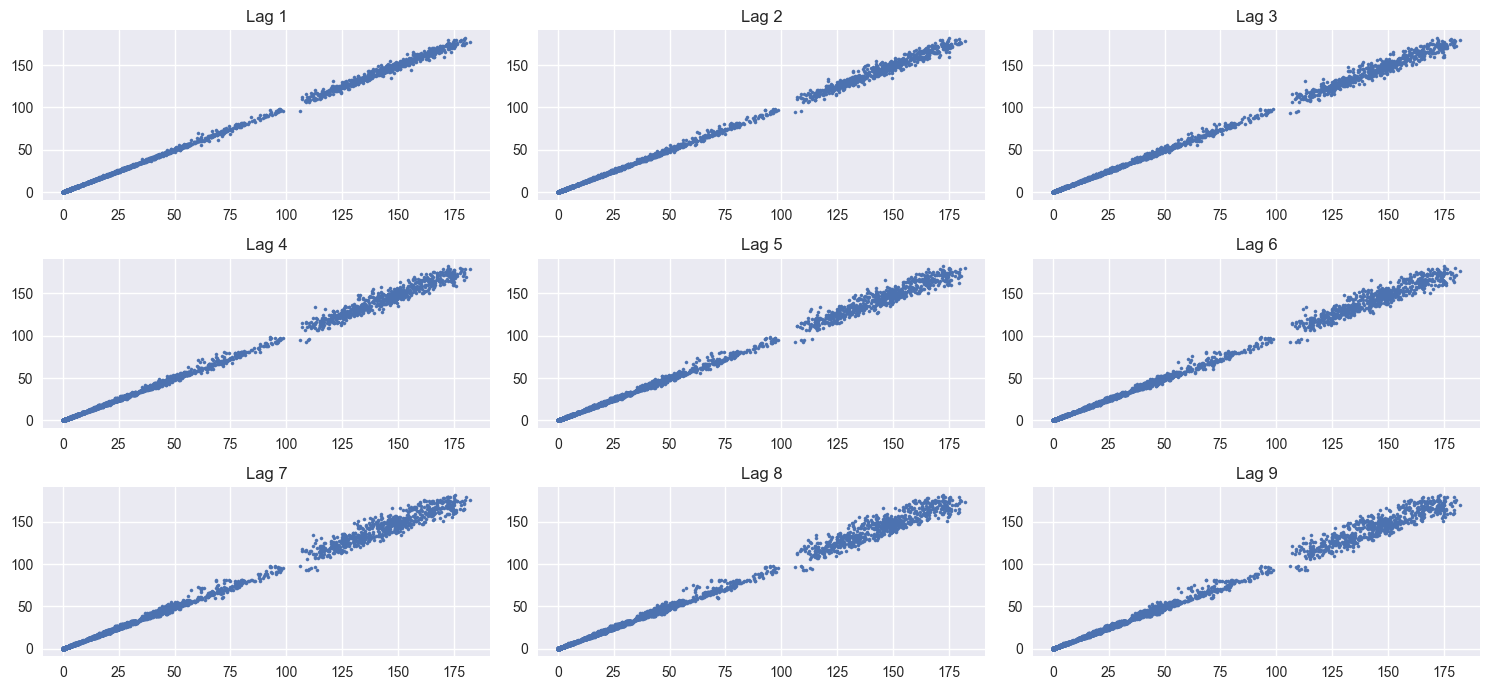

In [751]:
# Now let's look at the plots
fig, ax = plt.subplots(3, 3, figsize=(15, 7))
ax = ax.flatten()                         
for i in range(0,9):
    ax[i].scatter(lags['Close'], lags[f'Lag {i+1}'], s=5)
    ax[i].set_title(f'Lag {i+1}')
plt.tight_layout() # to avoid overlapping of subplots
plt.show()

From the plot above it really looks like the time series is non-stationarity. There is huge correlation between different lags and the original series, so ARIMA will be a really good model for predicting stock prices. 

We can also take a look at the autocorrelation function taken for all values of lag 20, that defines the correlation between the price and its value in another time period.

In [752]:
for i, val in enumerate(acf(data['Close'], nlags=20)):
    print(f"Autocorrelation at lag {i} is: {val}")

Autocorrelation at lag 0 is: 1.0
Autocorrelation at lag 1 is: 0.9988549155399105
Autocorrelation at lag 2 is: 0.9977270019800032
Autocorrelation at lag 3 is: 0.996617346202671
Autocorrelation at lag 4 is: 0.9955474979727161
Autocorrelation at lag 5 is: 0.9944875456002137
Autocorrelation at lag 6 is: 0.9934020496923872
Autocorrelation at lag 7 is: 0.9923179626491457
Autocorrelation at lag 8 is: 0.9911992102435643
Autocorrelation at lag 9 is: 0.9901151628960801
Autocorrelation at lag 10 is: 0.98901982573502
Autocorrelation at lag 11 is: 0.9879232136330256
Autocorrelation at lag 12 is: 0.986797587595533
Autocorrelation at lag 13 is: 0.9857693263093157
Autocorrelation at lag 14 is: 0.9847243146061408
Autocorrelation at lag 15 is: 0.9836558755659187
Autocorrelation at lag 16 is: 0.9825970693229885
Autocorrelation at lag 17 is: 0.9815241912913477
Autocorrelation at lag 18 is: 0.9804856605984787
Autocorrelation at lag 19 is: 0.9794486341186829
Autocorrelation at lag 20 is: 0.9784054340379775


We may want also to statistically test the hypotheses of having non-stationarity in our data. For this we'll use the Augmented Dickey-Fuller test.

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

- **Null Hypothesis**: The data is not stationary.

- **Alternative Hypothesis**: The data is stationary.

In [753]:
from statsmodels.tsa.stattools import adfuller

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
test = adfuller(data['Close'], autolag='AIC')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(output)

Results of Dickey Fuller Test:
Test Statistic                    2.141733
p-value                           0.998831
#Lags Used                       34.000000
Number of Observations Used    5849.000000
dtype: float64


As we can see the p-value is quite large, 0.99, so given that is greater than 0.05 we cannot reject the null hypotheses and hence confirm that our data is non-stationary and we'll need an ARIMA model and differencing to fit the data.

We can confirm that ARIMA is going to be a good model to be applied to this type of data. Even if the autocorrelation is decreasing as the lag increase the correlation remain still really high. 

The standard ARIMA (Auto Regressive Integrated Moving Average) models expect as input parameters 3 arguments p, d, q:
- $p$ is the number of lag observations.
- $d$ is the degree of differencing.
- $q$ is the size/width of the moving average window.

The forecasting equation is constructed as follows.  First, let $y$ denote the dth difference of Y, which means:
- if $d=0$ , $y_t = Y_t$
- if $d=1$ , $y_t = Y_t - Y_{t-1}$
- if $d=2$ , $y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) $

These $d$ transformations are needed to make the data stationary. In particular for this kind of series the differencing term will basically be the returns of the stock that as we explained before are stationary.

And in terms of $y$, the general forecasting equation is:

$$\hat{y_{t}} = \mu + \psi_1 y_{t-1} + \psi_2 y_{t-2} + ... + \psi_p y_{t-p} - \theta_1 e_{t-1} ... - \theta_1 e_{t-q}$$

where, 
- $\mu$ is the constant term
- $y_{t-1} ... y_{t-p} $ are the Auto Regressive terms, the lagged values of y (the stock price)
- $e_{t-1} ... e_{t-q}$ are the Moving Average terms, the lagged errors. This part of the time series is a stochastic component, a linear combination of $q$ lags of a white noise process. Usually $\theta_1$ is set to be equal to 1.

To identify the appropriate ARIMA model for Y, you begin by determining the order of differencing (d) needing to stationarize the series and remove the gross features of seasonality. Then, the stationarized series may still have autocorrelated errors, suggesting that some number of AR terms (p ≥ 1) and/or some number MA terms (q ≥ 1) are also needed in the forecasting equation.

Given that our series (and in general all time series of stocks price) is non-stationary and present very high autocorrelation, for sure we'll need $p≥0$ and $d≥0$.





##### Determine $d$

In order to first determine the degree of differencing we can use a function from the pmdarina library that will tell us the optimal degree of differencing to be used. 

In [754]:
from pmdarima.arima.utils import ndiffs

print('The optimal degree of differencing is d =', ndiffs(data['Close'], test='adf'))

The optimal degree of differencing is d = 1


We can also look at the std errors for each model using a difference order $d$, and use as a rule of thumb that the models with the smaller values of std error are the best.

In [755]:

for i in range(1, 5):
    model = ARIMA(data['Close'], order=(0,i,0))
    fit = model.fit()
    print(f"Std error for order difference of {i}:", fit.fittedvalues.std())

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Std error for order difference of 1: 45.67299203614712
Std error for order difference of 2: 45.73518106008036


/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Std error for order difference of 3: 45.79087852775025
Std error for order difference of 4: 45.98161816528072


As we can see, $d = 1 \ and \ d=2$ exhibit the lower standard errors. So we could guess to pick one model or the other. 
From a theoretical point of view however we may want to prefer the model with d=1. As Robert Nau in "Statistical forecasting:
notes on regression and time series analysis" points out *"The model with two orders of differencing assumes that the trend in the series is time-varying, hence it considers the distant future to be much more uncertain than does the model with only one order of differencing."*  and *The model with only one order of differencing assumes a constant average trend--it is essentially a fine-tuned random walk model with growth--and it therefore makes relatively conservative trend projections. It is also fairly optimistic about the accuracy with which it can forecast more than one period ahead. The model with two orders of differencing assumes a time-varying local trend--it is essentially a linear exponential smoothing model--and its trend projections are somewhat more more fickle.*

For this reasons, we may want 

##### Determine $p$

We can find $p$, the number of lags of the AR term to be included in the model, by inspecting Partial Autocorrelation plot (PACF), that can be used to draw a correlation between the time series (the first order differnce series) and its lag while the contribution from intermediate lags can be ignored. This plotting will let us know about the lags that are not required in the autoregression part. 

(-0.15, 1.0)

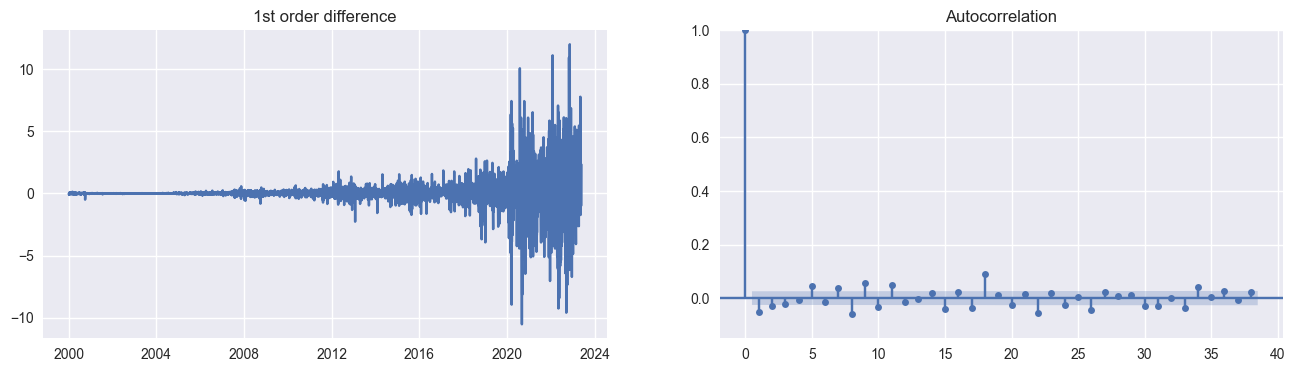

In [756]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = data['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("1st order difference")
plot_acf(diff, ax2)
ax2.set_ylim(-0.15, 1)

(-0.15, 1.0)

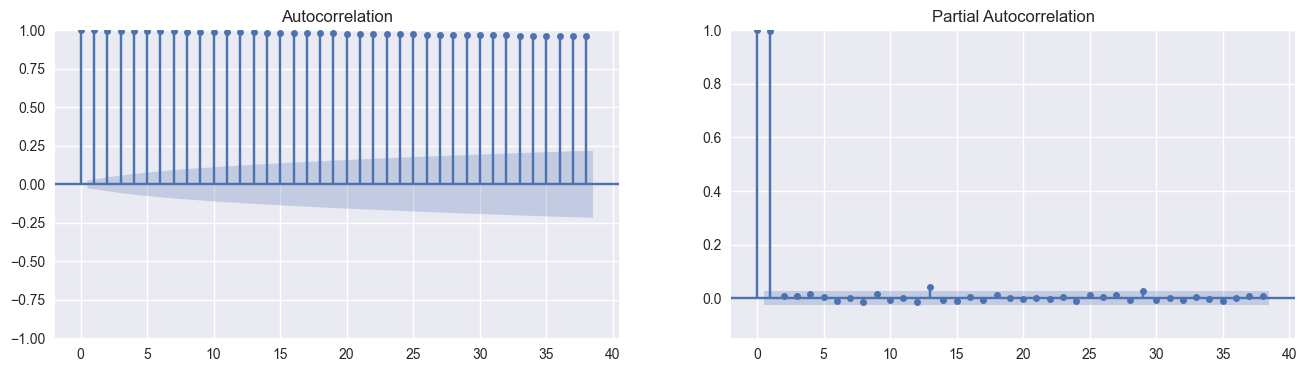

In [757]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.set_title("Autocorrelation")
ax2.set_title("Partial Autocorrelatio")
plot_acf(data['Close'], ax1)
plot_pacf(data['Close'], ax2)
ax2.set_ylim(-0.15, 1)

As we can see there is not a significative value of time lag that is significatively out of the limit so we could select a value of p equal to 0 (no time lags for the AR term).

##### Determine $q$

We can find $p$, the number of lags of the MA term to be included in the model, by inspecting Autocorrelation plot (ACF), that will tell us how much moving average is required to remove the autocorrelation from the stationary time series. 

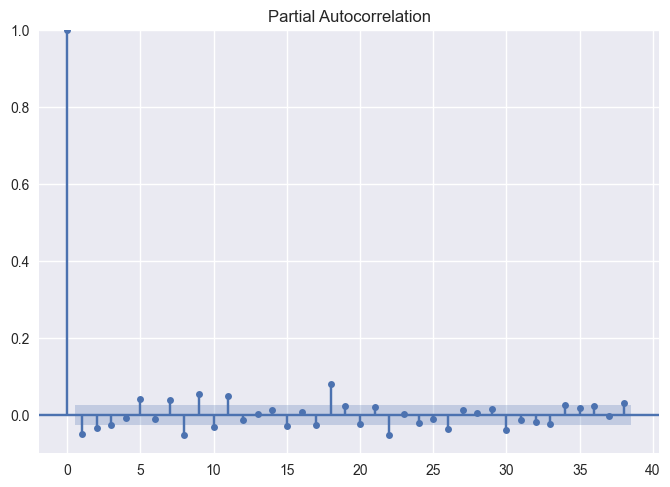

In [759]:
plot_pacf(data['Close'].diff().dropna())
plt.ylim(-0.1, 1);

If there is significant autocorrelation at lags 1 or 2, you should try setting q=1 if one of the following applies: (i) there is a non-seasonal difference in the model, (ii) the lag 1 autocorrelation is negative, and/or (iii) the residual autocorrelation plot is cleaner-looking (fewer, more isolated spikes) than the residual partial autocorrelation plot. 

If there is no non-seasonal difference in the model and/or the lag 1 autocorrelation is positive and/or the residual partial autocorrelation plot looks cleaner, then try p=1.

(-0.5, 1.0)

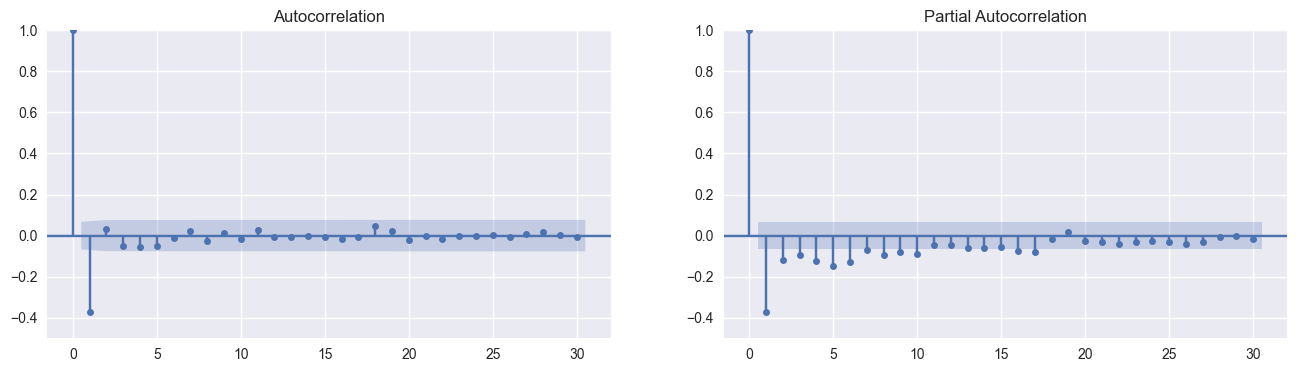

In [760]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.set_title("Autocorrelation")
ax2.set_title("Partial Autocorrelatio")
plot_acf(model_fit.resid, ax1)
plot_pacf(model_fit.resid, ax2)
ax1.set_ylim(-0.5, 1)
ax2.set_ylim(-0.5, 1)

In [764]:
model = ARIMA(data['Close'], order=(1,1,1))
model_fitted = model.fit()
forecast = model_fitted.forecast(steps=321) #forecast the next 30 days

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [765]:
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5884
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8835.621
Date:                Tue, 23 May 2023   AIC                          17677.242
Time:                        09:25:58   BIC                          17697.281
Sample:                             0   HQIC                         17684.208
                               - 5884                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4191      0.062      6.792      0.000       0.298       0.540
ma.L1         -0.4751      0.060     -7.877      0.000      -0.593      -0.357
sigma2         1.1804      0.006    187.843      0.000       1.168       1.193
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            127729.18
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):            1687.45   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [766]:
forecast

5884    174.218430
5885    174.226154
5886    174.229391
5887    174.230748
5888    174.231316
           ...    
6200    174.231726
6201    174.231726
6202    174.231726
6203    174.231726
6204    174.231726
Name: predicted_mean, Length: 321, dtype: float64

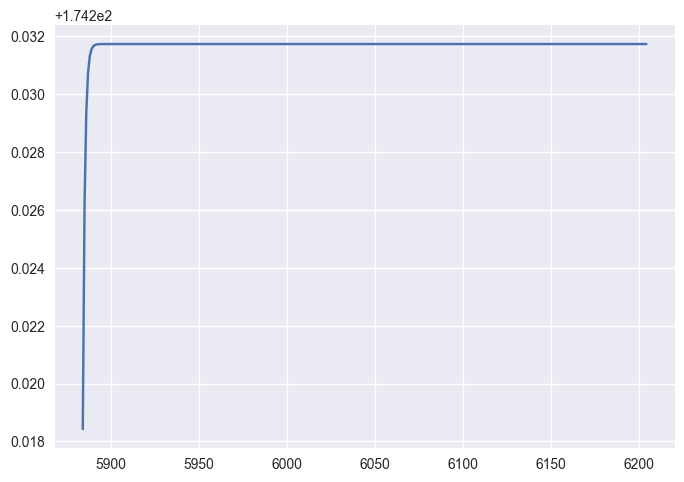

In [767]:
plt.plot(forecast)

In [474]:
ARIMA_model = pm.ARIMA(data = data['Close'], order=[2, 1, 1])

In [475]:
ARIMA_model.fit(y=data['Close'])

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['data']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



ARIMA(order=[2, 1, 1])

In [476]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  852
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -2061.186
Date:                Mon, 22 May 2023   AIC                           4132.372
Time:                        12:57:21   BIC                           4156.104
Sample:                             0   HQIC                          4141.462
                                - 852                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0153      0.043      0.357      0.721      -0.069       0.099
ar.L1          0.8278      0.326      2.539      0.011       0.189       1.467
ar.L2          0.0416      0.042      0.979      0.328      -0.042       0.125
ma.L1         -0.8870      0.322     -2.756      0.006      -1.518      -0.256
sigma2         7.4358      0.281     26.478      0.000       6.885       7.986
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                74.83
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

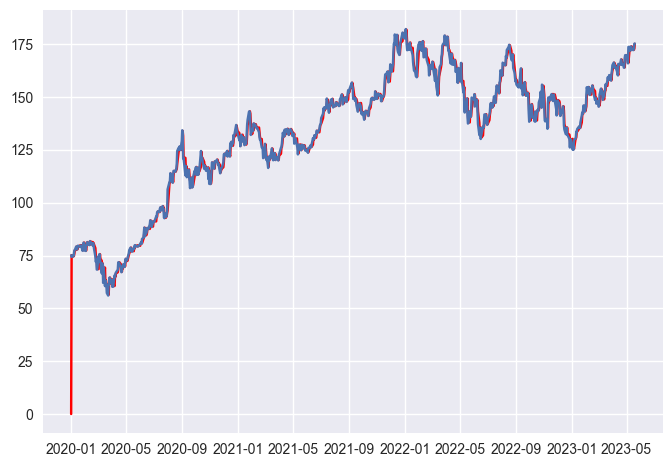

In [477]:
plt.plot(ARIMA_model.fittedvalues(), color = 'red')
plt.plot(data['Close'])

In [466]:
fitted, confint = ARIMA_model.predict(n_periods = 60, return_conf_int = True)
fitted

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['data']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



852      175.350260
853      174.020073
854      170.408169
855      164.132390
856      155.094837
857      141.916289
858      124.609580
859      102.464737
860       74.805630
861       41.086996
862        0.855290
863      -46.663841
864     -101.947439
865     -165.596587
866     -238.238928
867     -320.469900
868     -412.856870
869     -516.048159
870     -630.632642
871     -757.219669
872     -896.433355
873    -1048.893238
874    -1215.212305
875    -1396.025452
876    -1591.958335
877    -1803.641453
878    -2031.712353
879    -2276.810455
880    -2539.575591
881    -2820.655275
882    -3120.698004
883    -3440.355441
884    -3780.283635
885    -4141.141810
886    -4523.591739
887    -4928.299557
888    -5355.934382
889    -5807.168565
890    -6282.678114
891    -6783.142441
892    -7309.244148
893    -7861.669475
894    -8441.108025
895    -9048.252777
896    -9683.800206
897   -10348.450241
898   -11042.906211
899   -11767.874943
900   -12524.066727
901   -13312.195305


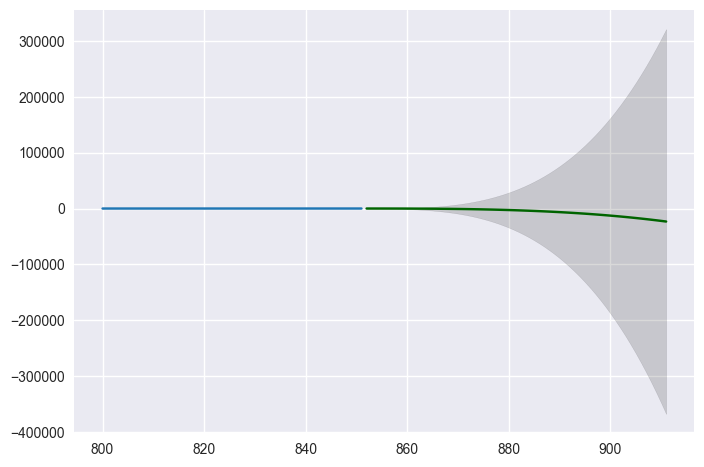

In [467]:
#lower_series = pd.Series(confint[:, 0], index=np.arange(852, 882))
#upper_series = pd.Series(confint[:, 1], index=np.arange(852, 882))

plt.plot(np.arange(800, len(data["Close"])), data["Close"][800:], color='#1f76b4')
plt.plot(fitted, color='darkgreen')
plt.fill_between(np.arange(852, 912), 
                    confint[:, 0], 
                    confint[:, 1], 
                    color='k', alpha=.15)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17693.329, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17680.006, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17678.911, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17695.634, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17673.927, Time=1.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17674.917, Time=3.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17675.027, Time=1.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17674.403, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17675.466, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17677.433, Time=1.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17677.242, Time=0.41 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 10.831 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:      

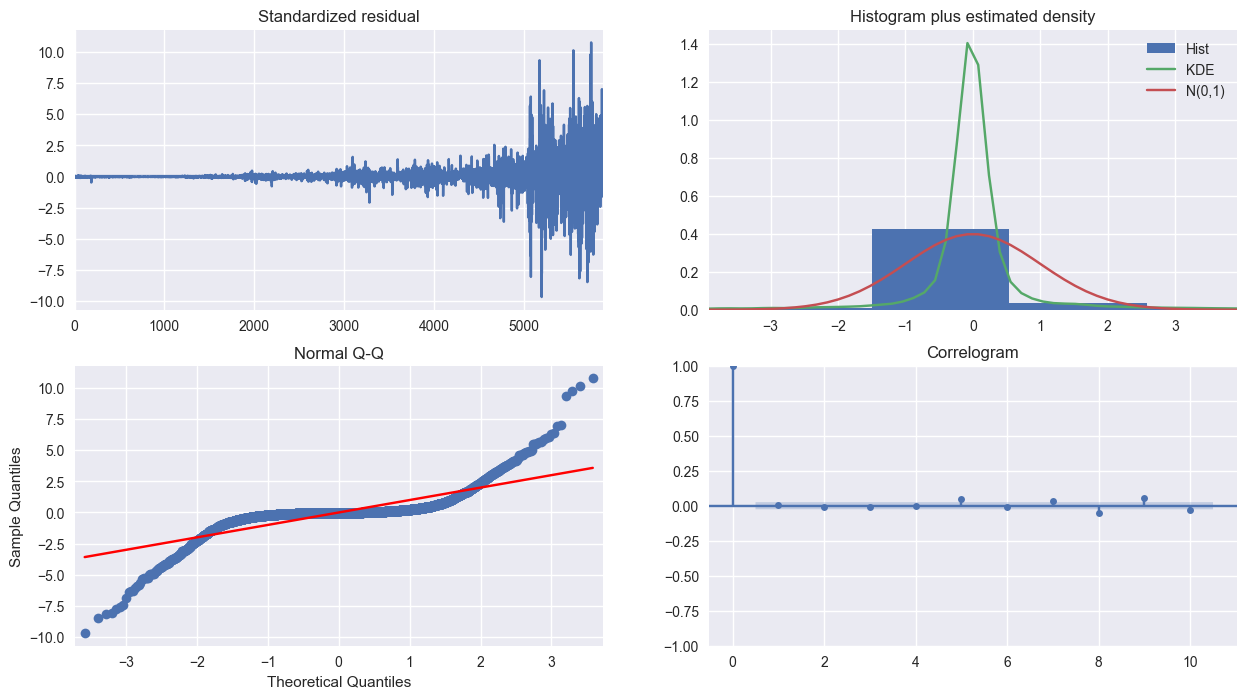

In [763]:
# AUTO ARIMA MODEL identification
model_autoARIMA = pm.auto_arima(data['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #use the stepwise algorithm
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [768]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5884
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -8832.964
Date:                Tue, 23 May 2023   AIC                          17673.927
Time:                        09:27:02   BIC                          17700.646
Sample:                             0   HQIC                         17683.215
                               - 5884                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0168      0.008      2.148      0.032       0.001       0.032
ar.L1          0.4277      0.060      7.137      0.000       0.310       0.545
ma.L1         -0.4847      0.059     -8.281      0.0

In [770]:
fitted_auto, confint_auto = model_autoARIMA.predict(n_periods=300, return_conf_int=True)
fitted_auto

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/tommasograndi/opt/anaconda3/envs/ITproject/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



5884    174.250036
5885    174.288285
5886    174.321491
5887    174.352541
5888    174.382669
           ...    
6179    182.949867
6180    182.979306
6181    183.008745
6182    183.038183
6183    183.067622
Length: 300, dtype: float64

In [782]:
confint_auto[:, 0]

array([172.12152589, 171.36273616, 170.80278212, 170.3378898 ,
       169.93105092, 169.56464325, 169.22871794, 168.9169736 ,
       168.62508563, 168.34991239, 168.08907547, 167.84071767,
       167.60335359, 167.375772  , 167.15696942, 166.9461032 ,
       166.7424575 , 166.54541808, 166.35445315, 166.16909867,
       165.9889468 , 165.81363689, 165.6428481 , 165.47629352,
       165.3137154 , 165.15488108, 164.99957977, 164.84761974,
       164.69882599, 164.5530383 , 164.4101095 , 164.26990408,
       164.13229688, 163.99717206, 163.86442213, 163.73394715,
       163.60565399, 163.47945572, 163.35527101, 163.23302368,
       163.11264224, 162.99405946, 162.87721209, 162.76204049,
       162.64848834, 162.53650243, 162.42603239, 162.31703051,
       162.2094515 , 162.10325238, 161.99839228, 161.8948323 ,
       161.79253541, 161.69146629, 161.59159124, 161.49287806,
       161.39529599, 161.29881561, 161.20340872, 161.10904835,
       161.01570859, 160.92336462, 160.8319926 , 160.74

In [785]:
print(len(np.arange(5884, 6184) + np.arange(5884, 6184)[::-1]))
print(len(confint_auto[:,0]+confint_auto[:,0][::-1]))

300
300


In [790]:
fig = go.Figure([go.Scatter(x=np.arange(5884, 6184), y=fitted_auto, line=dict(color='rgb(0,100,80)'),
                mode='lines'), 
                go.Scatter(
                x=np.arange(5884, 6184) + np.arange(5884, 6184)[::-1], # x, then x reversed
                y=confint_auto[:,0] + confint_auto[:,0][::-1], # upper, then lower reversed
                fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line=dict(color='rgba(255,255,255,0)'),
                showlegend=False
                )
            ])
fig.add_trace(go.Scatter(x=np.arange(0, 5885), y=data['Close']))

fig.show()

In [ ]:
def forecast(ARIMA_model, periods=30):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(data.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(data["Close"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA- Forecast of AAPL stock price")
    plt.show()

forecast(ARIMA_model)

### 2.3 PortFolio Optimization

In [ ]:
#Create a function to minimize, to find the portfolio with the highest sharpe Ratio, the highest risk-adjusted return

def sharpe_ptf(W, returns):
    
    ptf_risk = W.dot(returns.cov()).dot(W) ** 0.5 
    #calculating the portfolio risk, the portfolio standard deviation. 

    SR = W.dot(returns.mean()) / ptf_risk

    return -SR  #return negative value of the sharpe ratio in order to minimize it. 

In [ ]:
sharpe_ptf(weights, ret_df)

Explain how minimize function of scipy works

In [ ]:
#Is the equal weighted portfolio the best choice? 

#define the constraint, the sum of the weights of portfolio assets has to be equal to 0
const = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
# constraint is a dictionary
# type is the type of the constraint, in this case is an equality (eq)
# fun is the function defining the constraint, you are adding all the elements of the list 'weights'
# since it's an equality, you can write np.sum(x) = 1 (the constraint), as np.sum(x) - 1 and tell python is the function to solve the equality

#now minimize
results = minimize(sharpe_ptf, weights, ret_df, constraints = const)
results

# weights are the initial guess of the parameter to optimize
# the const is defined as a dictionary, 

Now we are going to define a function to calculate the optimal weights for the portfolio assets by maximizing the Sharpe Ratio calculated with the sharpe_ptf function.

In [ ]:
def ptf_optimization(stocks, commodities, start, short):

    assets = stocks + commodities
    tickers = assets
    df = yf.download(tickers, start = start)['Adj Close']

    ret_df = np.log(df/df.shift(1)) #calculate log returns for the selected assets
    
    # initial guess: all portfolios with equal weights
    weights = np.ones(len(ret_df.columns))/np.ones(len(ret_df.columns)).sum()

    #short is a boolean that defines whether the investor want to calculate the optimal portfolio by allowing also short-selling
    if short:
        const = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
        #now minimize
        results = minimize(sharpe_ptf, weights, ret_df, constraints = const)  
    else:
        # Optimization with positive weights (just long, no short positions)
        const_pos = [{'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1}, 
                    {'type' : 'ineq', 'fun' : lambda x: np.min(x)}]
        results = minimize(sharpe_ptf, weights, ret_df, constraints = const_pos)

    return results['x'] #return an array with weights of the ptf


In [12]:
commodities = {'Gold' : 'GC=F', 'Oil' : 'CL=F', 'Natural gas' : 'NG=F'}
list(commodities.keys())

['Gold', 'Oil', 'Natural gas']

## 3. Set up the desired plots to display the Data

### 3. Function and plots for the technical analysis

In [3]:
# Define the function to apply the technical indicators

indicators = ['Simple moving average', 'Expontential moving average', 'Relative strength index']


def apply_indicator(indicator, data, window):
    if indicator == 'Simple moving average':
        sma = SMAIndicator(data['Close'], window).sma_indicator()
        return pd.DataFrame({"Close" : data['Close'], "SMA" : sma})
    elif indicator == 'Expontential moving average':
        ema = EMAIndicator(data['Close'], window).ema_indicator()
        return pd.DataFrame({"Close" : data['Close'], "EMA" : ema})
    elif indicator == 'Relative strength index':
        rsi = RSIIndicator(data['Close']).rsi()
        return pd.DataFrame({"Close" : data['Close'], "RSI" : rsi})
    


In [55]:
data = yf.download('AAPL', start='2020-01-01')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.347939,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.634850,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.213615,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.869293,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.041489,132079200
...,...,...,...,...,...,...
2023-05-15,173.160004,173.210007,171.470001,172.070007,172.070007,37266700
2023-05-16,171.990005,173.139999,171.800003,172.070007,172.070007,42110300
2023-05-17,171.710007,172.929993,170.419998,172.690002,172.690002,57951600


In [35]:
ind_data = apply_indicator(indicators[0], data, 30)
ind_data

,Close,SMA
Date,,
2020-01-02,75.087502,NaN
2020-01-03,74.357498,NaN
2020-01-06,74.949997,NaN
2020-01-07,74.597504,NaN
2020-01-08,75.797501,NaN
...,...,...
2023-05-12,172.570007,167.028667
2023-05-15,172.070007,167.267667
2023-05-16,172.070007,167.464334


In [38]:
# When we plot the SMA or EMA with the closing price we can use a unique figure
fig = px.line(ind_data)
fig.update_xaxes(nticks = 20) #set the number of ticks for the x axis
fig.update_layout(height = 600)
fig.update_layout(yaxis_title='Close price')
fig.show()


In [34]:
# Instead when selecting RSI as indicator we will plot two different figures (two traces) since the scale is different

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1, vertical_spacing=0.065, shared_xaxes=True)

fig.add_trace(
    go.Scatter(x=ind_data.index, y=ind_data['Close'], name = 'Close price'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=ind_data.index, y=ind_data['RSI'], name = 'RSI'),
    row=2, col=1
)

fig['layout']['yaxis']['title']='Close price'
fig['layout']['yaxis2']['title']='RSI percentage'

fig.update_layout(height = 600) 
fig.show()